input_batch: [array([13,  4,  0]), array([15,  2,  8]), array([ 6,  1, 14]), array([13, 12,  0]), array([11,  3, 10]), array([7, 9, 5])]
target_batch: [array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.])]
Epoch: 001000 cost = 0.001497
Epoch: 002000 cost = 0.000338
Epoch: 003000 cost = 0.000132
Epoch: 004000 cost = 0.000063
Epoch: 005000 cost = 0.000033
sorry hate you is Bad Mean...


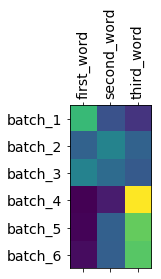

attention [[0.6205841  0.23582733 0.14358859]
 [0.2913372  0.41461518 0.29404762]
 [0.41089877 0.3261207  0.26298046]
 [0.00440843 0.07524929 0.92034227]
 [0.01241719 0.28453106 0.7030518 ]
 [0.03592721 0.2825245  0.6815483 ]]


'\n\n# 3 words sentences (=sequence_length is 3)\nsentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]\nlabels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.\n\n'

In [4]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode
  Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
'''
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tf.reset_default_graph()

# Bi-LSTM(Attention) Parameters
embedding_dim = 2
n_hidden = 5 # number of hidden units in one cell
n_step = 3 # all sentence is consist of 3 words
n_class = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

input_batch = []
for sen in sentences:
    input_batch.append(np.asarray([word_dict[n] for n in sen.split()]))
print('input_batch:',input_batch)
target_batch = []
for out in labels:
    target_batch.append(np.eye(n_class)[out]) # ONE-HOT : To using Tensor Softmax Loss function
print('target_batch:',target_batch)

# LSTM Model
X = tf.placeholder(tf.int32, [None, n_step])
Y = tf.placeholder(tf.int32, [None, n_class])
out = tf.Variable(tf.random_normal([n_hidden * 2, n_class]))

embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_dim]))
input = tf.nn.embedding_lookup(embedding, X) # [batch_size, len_seq, embedding_dim]

lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)
lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)

# output : [batch_size, len_seq, n_hidden], states : [batch_size, n_hidden]
output, final_state = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell, input, dtype=tf.float32)

# Attention
output = tf.concat([output[0], output[1]], 2)                             # output[0] : lstm_fw, output[1] : lstm_bw
# 最后的隐含层包含记忆单元C，和隐含层H
final_hidden_state = tf.concat([final_state[1][0], final_state[1][1]], 1) # final_hidden_state : [batch_size, n_hidden * num_directions(=2)]
final_hidden_state = tf.expand_dims(final_hidden_state, 2)                # final_hidden_state : [batch_size, n_hidden * num_directions(=2), 1]
# 每一步的权重
attn_weights = tf.squeeze(tf.matmul(output, final_hidden_state), 2) # attn_weights : [batch_size, n_step]
# 权重在step上归一化，
soft_attn_weights = tf.nn.softmax(attn_weights, 1) #  [batch_size, n_step]
# 加权求和# context : [batch_size, n_hidden * num_directions(=2), 1]
# [batch_size, n_hidden * num_directions(=2), n_step] *  [batch_size, n_step, 1]
context = tf.matmul(tf.transpose(output, [0, 2, 1]), tf.expand_dims(soft_attn_weights, 2)) 

context = tf.squeeze(context, 2) # [batch_size, n_hidden * num_directions(=2)]

model = tf.matmul(context, out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Model-Predict
hypothesis = tf.nn.softmax(model)
predictions = tf.argmax(hypothesis, 1)

# Training
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(5000):
        _, loss, attention = sess.run([optimizer, cost, soft_attn_weights], feed_dict={X: input_batch, Y: target_batch})
        if (epoch + 1)%1000 == 0:
            print('Epoch:', '%06d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]

    predict = sess.run([predictions], feed_dict={X: tests})
    result = predict[0][0]
    if result == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + ['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels([''] + ['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()
    # 看一下注意力权重
    print('attention',attention)
    
'''

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

'''